# Loading modules, setting directory, loading data

In [ ]:
##
'''
Model#	Model-Name
1	Genomic-PC
2	TuTr-Binary
7	Integrated 
3	Embedded
10	PCPT (avg)
'''

In [1]:
import os
import math
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import scipy.stats as stats
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l1
from tensorflow.keras import Sequential, layers, models, optimizers, losses, metrics
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, CSVLogger
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import f1_score, precision_score, recall_score, matthews_corrcoef
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix, accuracy_score

2024-12-05 17:35:12.097966: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
## Create and Set Directory

run_dir = '../Split_4CV_Combined_10sep'
os.makedirs(run_dir, exist_ok=True)
os.chdir(run_dir)

In [3]:
base_path = '../Split_4CV_0_10sep/'
parts = range(1,5)

df_meta = {}
df_pca = {}
df_tutr = {}
df_y = {}

df_linh_meta = {}
df_linh_pca = {}
df_linh_tutr = {}
df_linh_y = {}

for part in parts:
    df_meta[part] = pd.read_csv(f'{base_path}df_meta_{part}.csv', index_col=0)
    df_pca[part] = pd.read_csv(f'{base_path}df_pca200_{part}.csv', index_col=0)
    df_tutr[part] = pd.read_csv(f'{base_path}df_tutr_{part}.csv', index_col=0)
    df_y[part] = pd.read_csv(f'{base_path}df_y_{part}.csv', index_col=0)
    
    df_linh_meta[part] = pd.read_csv(f'{base_path}df_linh_meta_{part}.csv', index_col=0)
    df_linh_pca[part] = pd.read_csv(f'{base_path}df_linh_pca_{part}.csv', index_col=0)
    df_linh_tutr[part] = pd.read_csv(f'{base_path}df_linh_tutr_{part}.csv', index_col=0)
    df_linh_y[part] = pd.read_csv(f'{base_path}df_linh_y_{part}.csv', index_col=0)

    print(f'Part {part}:')
    print(f'df_meta\t\t: {df_meta[part].shape}')
    print(f'df_pca\t\t: {df_pca[part].shape}')
    print(f'df_tutr\t\t: {df_tutr[part].shape}')
    print(f'df_y\t\t: {df_y[part].shape}')
    
    print(f'df_linh_meta\t: {df_linh_meta[part].shape}')
    print(f'df_linh_pca\t: {df_linh_pca[part].shape}')
    print(f'df_linh_tutr\t: {df_linh_tutr[part].shape}')
    print(f'df_linh_y\t: {df_linh_y[part].shape}')
    print('-------------------')

Part 1:
df_meta		: (504, 4)
df_pca		: (504, 200)
df_tutr		: (504, 24)
df_y		: (504, 1)
df_linh_meta	: (261, 4)
df_linh_pca	: (261, 200)
df_linh_tutr	: (261, 24)
df_linh_y	: (261, 1)
-------------------
Part 2:
df_meta		: (493, 4)
df_pca		: (493, 200)
df_tutr		: (493, 24)
df_y		: (493, 1)
df_linh_meta	: (257, 4)
df_linh_pca	: (257, 200)
df_linh_tutr	: (257, 24)
df_linh_y	: (257, 1)
-------------------
Part 3:
df_meta		: (475, 4)
df_pca		: (475, 200)
df_tutr		: (475, 24)
df_y		: (475, 1)
df_linh_meta	: (244, 4)
df_linh_pca	: (244, 200)
df_linh_tutr	: (244, 24)
df_linh_y	: (244, 1)
-------------------
Part 4:
df_meta		: (466, 4)
df_pca		: (466, 200)
df_tutr		: (466, 24)
df_y		: (466, 1)
df_linh_meta	: (241, 4)
df_linh_pca	: (241, 200)
df_linh_tutr	: (241, 24)
df_linh_y	: (241, 1)
-------------------


# Defining functions

In [4]:
custom_palette = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', 
                  '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', 
                  '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', 
                  '#000075', '#808080', '#ffffff', '#000000']

sns.set_palette(custom_palette)
sns.set_style("whitegrid")

In [5]:
def mcc_score_fun(y_true, y_pred):
    # Ensure predictions are rounded to 0 or 1
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos
    
    # Ensure true values are rounded to 0 or 1
    y_true_pos = K.round(K.clip(y_true, 0, 1))
    y_true_neg = 1 - y_true_pos
    
    # Compute true positives, true negatives, false positives, false negatives
    tp = K.sum(y_true_pos * y_pred_pos)
    tn = K.sum(y_true_neg * y_pred_neg)
    fp = K.sum(y_true_neg * y_pred_pos)
    fn = K.sum(y_true_pos * y_pred_neg)
    
    # Calculate the numerator and denominator of the MCC
    numerator = (tp * tn) - (fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
    
    # Add epsilon to the denominator to avoid division by zero
    mcc = numerator / (denominator + K.epsilon())
    
    return mcc

In [6]:
def f1_score_fun(y_true, y_pred):
    # Ensure predictions are rounded to 0 or 1
    y_pred = K.round(y_pred)
    
    # Calculate true positives, false positives, and false negatives
    tp = K.sum(K.cast(y_true * y_pred, 'float'), axis=0)
    fp = K.sum(K.cast((1 - y_true) * y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true * (1 - y_pred), 'float'), axis=0)
    
    # Calculate precision and recall
    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())
    
    # Calculate F1 score
    f1 = 2 * precision * recall / (precision + recall + K.epsilon())
    
    # Return mean F1 score across all classes
    return K.mean(f1)

In [7]:
def plot_training_metrics(history):
    # Automatically detect metrics by filtering out the keys
    metric_keys = [key for key in history.history.keys() if not key.startswith('val_')]

    # Calculate the number of rows and columns needed
    num_metrics = len(metric_keys)
    num_cols = 4
    num_rows = math.ceil(num_metrics / num_cols)  # Ensure enough rows
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 4))
    axes = axes.flatten()  # Flatten in case it's a multi-dimensional array

    for idx, metric in enumerate(metric_keys):
        ax = axes[idx]
        
        # Get the corresponding validation metric key
        val_metric = f'val_{metric}'
        
        # Plot the training and validation curves
        ax.plot(history.history[metric], label=f'Training {metric.capitalize()}', color='tab:blue')
        ax.plot(history.history[val_metric], label=f'Validation {metric.capitalize()}', color='tab:orange')
        
        # Annotate the last value
        last_train_value = history.history[metric][-1]
        last_val_value = history.history[val_metric][-1]
        ax.plot(len(history.history[metric])-1, last_train_value, 'o', color='black')
        ax.text(len(history.history[metric])-1, last_train_value, f'{last_train_value:.4f}', 
                 color='black', ha='right', va='bottom', fontsize=10, fontweight='bold')

        ax.plot(len(history.history[val_metric])-1, last_val_value, 'o', color='black')
        ax.text(len(history.history[val_metric])-1, last_val_value, f'{last_val_value:.4f}', 
                 color='black', ha='right', va='bottom', fontsize=10, fontweight='bold')
        
        # Annotate the highest/lowest value for training
        minmax_train = max(history.history[metric]) if 'loss' not in metric else min(history.history[metric])
        minmax_val = max(history.history[val_metric]) if 'loss' not in val_metric else min(history.history[val_metric])
        
        minmax_train_index = history.history[metric].index(minmax_train)
        minmax_val_index = history.history[val_metric].index(minmax_val)

        ax.plot(minmax_train_index, minmax_train, 'o', color='darkblue')
        ax.text(minmax_train_index, minmax_train, f'{minmax_train:.4f}', 
                 color='darkblue', ha='right', va='bottom', fontsize=10, fontweight='bold')

        ax.plot(minmax_val_index, minmax_val, 'o', color='darkorange')
        ax.text(minmax_val_index, minmax_val, f'{minmax_val:.4f}', 
                 color='darkorange', ha='right', va='bottom', fontsize=10, fontweight='bold')
        
        ax.set_xlabel('Epochs')
        ax.set_ylabel(metric.capitalize())
        ax.set_title(f'{metric.capitalize()}')
        ax.legend()
    
    # Hide any unused subplots if there are fewer metrics than grid spaces
    for i in range(num_metrics, num_rows * num_cols):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()


In [8]:
def print_last_metrics(history, metrics):
    if metrics is None:
        metrics = ['mcc_score', 'f1_score', 'accuracy', 'val_mcc_score', 'val_f1_score', 'val_accuracy']
    
    last_metrics = {metric: history.history[metric][-1] for metric in metrics if metric in history.history}
    
    # Define a formatted string with headers and extracted metric values
    print(f"{'Metric':<15}{'Training':<15}{'Validation':<15}")
    print(f"{'-'*45}")
    print(f"{'MCC Score':<15}{last_metrics.get('mcc_score', 0):<15.4f}{last_metrics.get('val_mcc_score', 0):<15.4f}")
    print(f"{'F1 Score':<15}{last_metrics.get('f1_score', 0):<15.4f}{last_metrics.get('val_f1_score', 0):<15.4f}")
    print(f"{'Accuracy':<15}{last_metrics.get('accuracy', 0):<15.4f}{last_metrics.get('val_accuracy', 0):<15.4f}")
    print(f"{'-'*45}")
    print(f"Total Epochs: {len(history.history['loss'])}")
    print(f"{'-'*45}")
    

In [9]:
def save_embeddings(model,model_num,data,data_type,data_num,data_index):

    embb_mat = model.predict(data)
    print(f"Embeddings: {data_type:<15}Min: {embb_mat.min():<15.4f}Max: {embb_mat.max():<15.4f}")
    embb_mat_norm = embb_mat / 1
    embb_mat_norm_df = pd.DataFrame(embb_mat_norm, index=data_index)
    embb_mat_norm_df.to_csv(f'Model{model_num}_embb_{data_num}{data_type}.csv')

In [10]:
def get_metric_score(y_true, y_pred, opti_threshold):
    score_dict = dict()
    confusion = confusion_matrix(y_true, y_pred>opti_threshold)
    score_dict['f1_score'] = f1_score(y_true, y_pred>opti_threshold)
    score_dict['accuracy'] = accuracy_score(y_true, y_pred>opti_threshold)
    score_dict['mcc'] = matthews_corrcoef(y_true, y_pred>opti_threshold)
    score_dict['recall'] = recall_score(y_true, y_pred>opti_threshold)
    score_dict['precision'] = precision_score(y_true, y_pred>opti_threshold)
    score_dict['auc'] = roc_auc_score(y_true, y_pred)
    score_dict['TP'] = confusion[1, 1]
    score_dict['TN'] = confusion[0, 0]
    score_dict['FP'] = confusion[0, 1]
    score_dict['FN'] = confusion[1, 0]
    return score_dict

In [11]:
def loocv_prob_to_scores(df_prob,name, ):
    
    print(f'{name}_analysis')
    
    # ROC curve & AUC calculation
    y_predicted =df_prob['PredProb']
    y_true_class = df_prob['BestResCatCalc']
    fpr, tpr, thresholds = roc_curve(y_true_class, y_predicted)
    roc_auc = auc(fpr, tpr)
    
    # Plot
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.savefig(f'ROC_Curve_{name}.png', dpi=600)
    plt.show()
    
    optimal_idx = np.argmax(tpr - fpr)    # Find the index of the optimal threshold
    optimal_threshold = round(thresholds[optimal_idx], 2)
    print("Optimal Threshold : ", optimal_threshold)
    
    L = list()
    for tumor in df_prob['Tumor'].unique():
        df_tmp = df_prob.loc[df_prob['Tumor']==tumor,:]
        for treatment in df_tmp['Treatment'].unique():
            df_tmp_1 = df_tmp.loc[df_tmp['Treatment']==treatment,:]
            y_true = df_tmp_1['BestResCatCalc']
            y_pred = df_tmp_1['PredProb']
            score_dict = get_metric_score(y_true, y_pred,optimal_threshold)# 0.5)
            temp_list = list()
            for key in score_dict:
                temp_list.append([tumor, treatment, key, score_dict[key]])
            L.append(pd.DataFrame(temp_list, columns=['Tumor', 'Treatment', 'Metric', 'Score']))
    df_results = pd.concat(L)
    df_results.to_csv(f'LOOCV_scores_{name}.csv', index=None)

In [12]:
def create_compile_model(input_dim,param,funcIn,funcOut,DropRate):
    
    model = models.Sequential([layers.Input(shape=(input_dim,)),
                               layers.Dense(units=param["Hunits"],activation=funcIn),
                               layers.Dropout(DropRate),layers.Dense(1, activation=funcOut)])   
    model.compile(optimizer=optimizers.Adam(learning_rate=param["Lrate"]),
                  loss='binary_crossentropy',metrics=[mcc_score_fun,f1_score_fun,'accuracy'])
    
    
    model_embb = models.Sequential([layers.Input(shape=(input_dim,)),
                                    layers.Dense(units=param["Hunits"],activation=funcIn)])
    model_embb.layers[0].set_weights(model.layers[0].get_weights())
    model_embb.compile(optimizer=optimizers.Adam(learning_rate=param["Lrate"]),
                       loss='binary_crossentropy',metrics=[mcc_score_fun,f1_score_fun,'accuracy'])
    
    return model, model_embb


In [13]:
def read_and_concat_predprob(mo_num):
    df_total_combined = pd.DataFrame()
    df_linh_combined = pd.DataFrame()
    for part in parts:
        df_total_part = pd.read_csv(f"./Model{mo_num}_predicted_{part}.csv", index_col=0)
        df_linh_part = pd.read_csv(f"./Model{mo_num}_predicted_linh_{part}.csv", index_col=0)
        df_total_combined = pd.concat([df_total_combined,df_total_part])
        df_linh_combined = pd.concat([df_linh_combined,df_linh_part])
    print(part)
    print(df_total_part.shape, df_linh_part.shape)
    print(df_total_combined.shape, df_linh_combined.shape)    
    return df_total_combined, df_linh_combined

In [14]:
def convert_predprob_to_scores(dict_predprobs,mo_num,name):
    loocv_prob_to_scores(dict_predprobs[mo_num], f"Model{mo_num}_{name}_scores")
    df_mo_scores = pd.read_csv(f"LOOCV_scores_Model{mo_num}_{name}_scores.csv", index_col=None)
    df_mo_scores['model'] = f'Model{mo_num}-{name}'
    return df_mo_scores

In [15]:
#RUN -ONCE

#df_total_prob = {}
#df_linh_prob = {}
#model_scores = pd.DataFrame()

In [17]:
df_rfomc = pd.read_csv("../../performance_scores_rfomc_brca+crc.csv",index_col=0)

In [18]:
df_BaseMax = pd.read_csv("../../performance_scores_BaseMax.csv",index_col=None)
df_BaseMax['model'] = 'BaseMax'

In [21]:
df_BaseMax_linh = df_BaseMax[df_BaseMax['Tumor'].isin(['BRCA','CRC'])].copy()
df_BaseMax_linh.loc['model'] = 'BaseMaxLinh'

In [23]:
model_scores = pd.concat([model_scores,df_rfomc])
model_scores = pd.concat([model_scores,df_BaseMax])
model_scores = pd.concat([model_scores,df_BaseMax_linh])

In [24]:
model_scores.model.unique()

array(['RF-OMC', 'BaseMax', 'BaseMaxLinh'], dtype=object)

In [25]:
metrics_list = np.sort(model_scores['Metric'].unique())
metrics_list_linh = metrics_list[-4::]

In [26]:
metrics_list, metrics_list_linh

(array(['BaseMaxLinh', 'FN', 'FP', 'TN', 'TP', 'accuracy', 'auc',
        'f1_score', 'mcc', 'precision', 'recall'], dtype=object),
 array(['f1_score', 'mcc', 'precision', 'recall'], dtype=object))

# Model 1 PCA of genomic ## included

In [ ]:
history_list_model1 = []

seed1=100

param1 = {"Lrate": 0.0001, "Bsize": 64,"Epo": 500,"Hunits": 8}

funcIn1 = 'relu'
funcOut1 = 'sigmoid'
DropOut1 = 0.2

EpoWait1 = 100

tf.random.set_seed(seed1)
np.random.seed(seed1)

for validation_part in parts:
    train_parts = [part for part in parts if part != validation_part]

    X_train = pd.concat([df_pca[part] for part in train_parts])
    y_train = pd.concat([df_y[part] for part in train_parts])
    meta_train = pd.concat([df_meta[part] for part in train_parts])

    X_val = df_pca[validation_part]
    y_val = df_y[validation_part]
    meta_val = df_meta[validation_part]

    X_linh = df_linh_pca[validation_part]
    y_linh = df_linh_y[validation_part]
    meta_linh = df_linh_meta[validation_part]
    
    #defining model and paramters
    input_dim1 = X_train.shape[1]
    mymodel1, mymodel1_embb = create_compile_model(input_dim1,param1,funcIn1,funcOut1,DropOut1)

    #callbacks
    parent_log_dir1 = 'Split_4CV_Model1_log'
    os.makedirs(parent_log_dir1, exist_ok=True)
    log_filepath1 = os.path.join(parent_log_dir1,f'training_log_-{validation_part}.csv')
    checkpoint_filepath1 = os.path.join(parent_log_dir1, f'checkpoint_-{validation_part}.h5')
    csv_logger1 = CSVLogger(log_filepath1)
    callback1 = EarlyStopping(monitor='val_loss',min_delta=0,patience=EpoWait1, verbose=0,restore_best_weights=True)
    model_checkpoint1 = ModelCheckpoint(filepath=checkpoint_filepath1,save_best_only=True,save_weights_only=True, 
                                       monitor='val_loss',mode='min',verbose=0)

    #training
    history1 = mymodel1.fit(X_train, y_train, validation_data=(X_val, y_val),shuffle=True,
                            epochs=param1["Epo"],batch_size=param1["Bsize"],
                            verbose=0,callbacks=[callback1, csv_logger1, model_checkpoint1])
    #Training_Results
    print(f"{'Fold':<15}{validation_part}")

    print_last_metrics(history1,None)

    #Saving predicitons
    X_predicted = pd.DataFrame(mymodel1.predict(X_val), columns=['PredProb'], index=meta_val.index)
    X_predicted_df = pd.concat([meta_val,X_predicted], ignore_index=False, axis=1)
    X_predicted_df.to_csv(f'Model1_predicted_{validation_part}.csv')
    
    X_linh_predicted = pd.DataFrame(mymodel1.predict(X_linh), columns=['PredProb'], index=meta_linh.index)
    X_linh_predicted_df = pd.concat([meta_linh,X_linh_predicted], ignore_index=False, axis=1)
    X_linh_predicted_df.to_csv(f'Model1_predicted_linh_{validation_part}.csv')

    #Extracting embeddings
    save_embeddings(mymodel1_embb,model_num=1,
                    data=X_train,data_type='not',data_num=validation_part,data_index=meta_train.index)
    save_embeddings(mymodel1_embb,model_num=1,
                    data=X_val,data_type='test',data_num=validation_part,data_index=meta_val.index)
    save_embeddings(mymodel1_embb,model_num=1,
                    data=X_linh,data_type='linh',data_num=validation_part,data_index=meta_linh.index)
    
    #Plot_training_results
    plot_training_metrics(history1)
    
    #saving history in list
    history_list_model1.append(history1)

4
(466, 5) (241, 5)
(1938, 5) (1003, 5)
Model1_total_scores_analysis


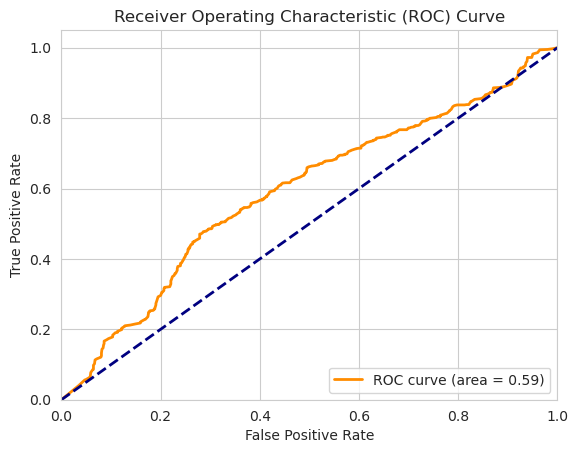

Optimal Threshold :  0.67
Model1_linh_scores_analysis


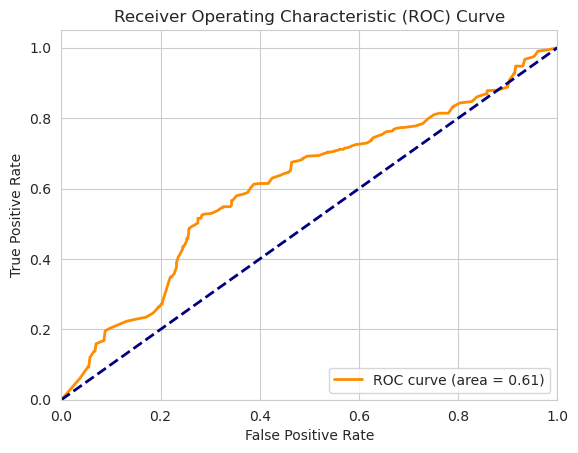

Optimal Threshold :  0.64


In [27]:
df_total_prob[1], df_linh_prob[1] = read_and_concat_predprob(1)
model_scores = pd.concat([model_scores,convert_predprob_to_scores(df_total_prob,1,'total')])
model_scores = pd.concat([model_scores,convert_predprob_to_scores(df_linh_prob,1,'linh')])

In [28]:
model_scores.model.unique()

array(['RF-OMC', 'BaseMax', 'BaseMaxLinh', 'Model1-total', 'Model1-linh'],
      dtype=object)

In [29]:
linh_models = ['BaseMaxLinh','RF-OMC'] + [mo for mo in model_scores['model'].unique() if 'linh' in mo]

In [30]:
linh_models

['BaseMaxLinh', 'RF-OMC', 'Model1-linh']

# Model 2 of TuTr only # included

4
(466, 5) (241, 5)
(1938, 5) (1003, 5)
Model2_total_scores_analysis


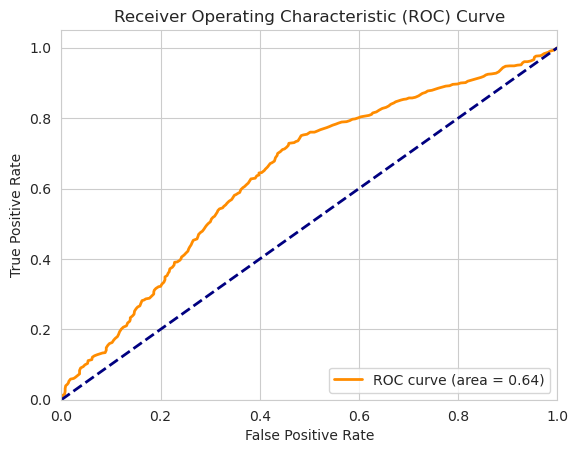

Optimal Threshold :  0.5


/home/shruti/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shruti/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shruti/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shruti/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/met

Model2_linh_scores_analysis


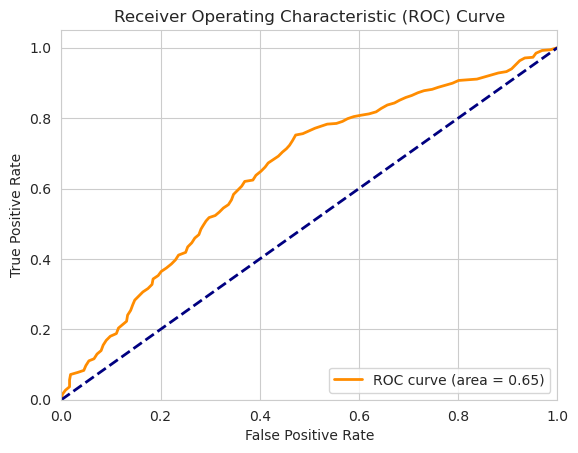

Optimal Threshold :  0.47


/home/shruti/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shruti/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shruti/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shruti/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/met

In [31]:
df_total_prob[2], df_linh_prob[2] = read_and_concat_predprob(2)
model_scores = pd.concat([model_scores,convert_predprob_to_scores(df_total_prob,2,'total')])
model_scores = pd.concat([model_scores,convert_predprob_to_scores(df_linh_prob,2,'linh')])

In [32]:
model_scores.model.unique()

array(['RF-OMC', 'BaseMax', 'BaseMaxLinh', 'Model1-total', 'Model1-linh',
       'Model2-total', 'Model2-linh'], dtype=object)

In [33]:
linh_models = ['BaseMaxLinh','RF-OMC'] + [mo for mo in model_scores['model'].unique() if 'linh' in mo]

In [34]:
linh_models

['BaseMaxLinh', 'RF-OMC', 'Model1-linh', 'Model2-linh']

# Model 1&2 - Combined # included

4
(466, 5) (241, 5)
(1938, 5) (1003, 5)
Model3_total_scores_analysis


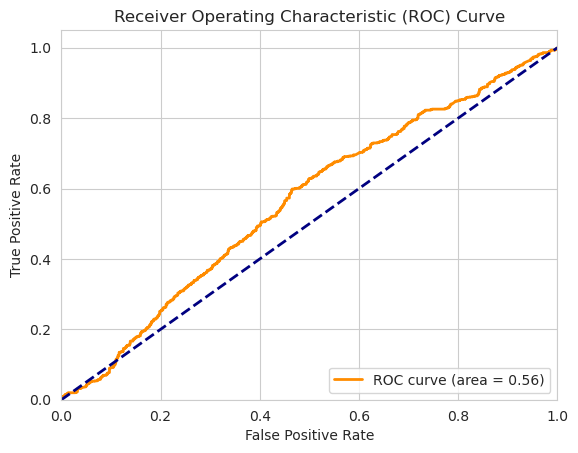

Optimal Threshold :  0.51
Model3_linh_scores_analysis


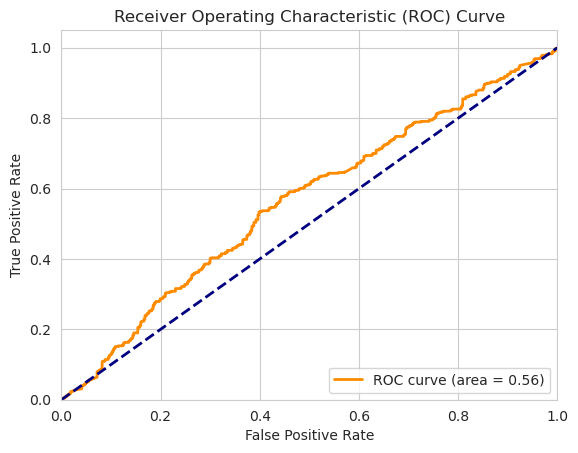

Optimal Threshold :  0.51


In [35]:
df_total_prob[3], df_linh_prob[3] = read_and_concat_predprob(3)
model_scores = pd.concat([model_scores,convert_predprob_to_scores(df_total_prob,3,'total')])
model_scores = pd.concat([model_scores,convert_predprob_to_scores(df_linh_prob,3,'linh')])

In [36]:
model_scores.model.unique()

array(['RF-OMC', 'BaseMax', 'BaseMaxLinh', 'Model1-total', 'Model1-linh',
       'Model2-total', 'Model2-linh', 'Model3-total', 'Model3-linh'],
      dtype=object)

In [37]:
linh_models = ['BaseMaxLinh','RF-OMC'] + [mo for mo in model_scores['model'].unique() if 'linh' in mo]

In [38]:
linh_models

['BaseMaxLinh', 'RF-OMC', 'Model1-linh', 'Model2-linh', 'Model3-linh']

# Model7 - original PCPT

4
(466, 5) (241, 5)
(1938, 5) (1003, 5)
Model7_total_scores_analysis


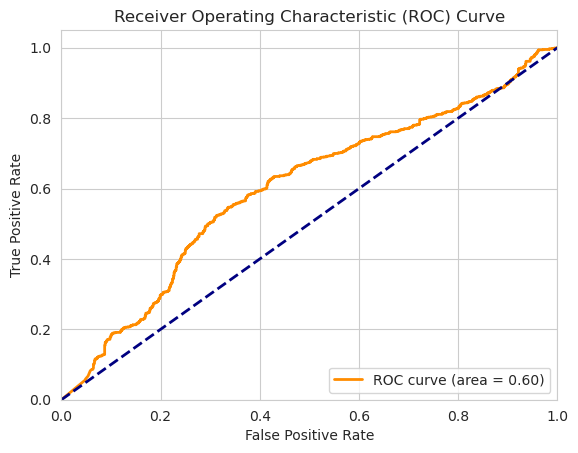

Optimal Threshold :  0.58
Model7_linh_scores_analysis


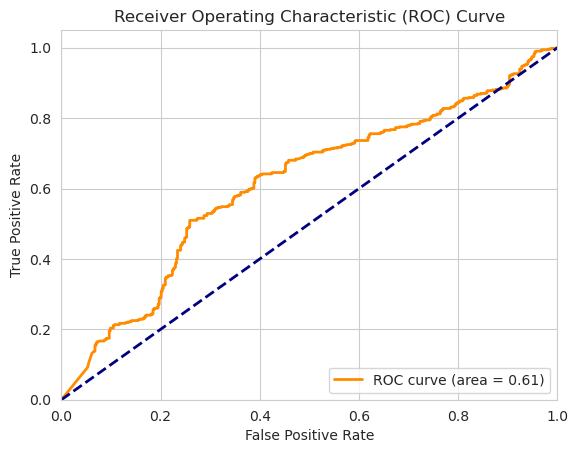

Optimal Threshold :  0.68


In [39]:
df_total_prob[7], df_linh_prob[7] = read_and_concat_predprob(7)
model_scores = pd.concat([model_scores,convert_predprob_to_scores(df_total_prob,7,'total')])
model_scores = pd.concat([model_scores,convert_predprob_to_scores(df_linh_prob,7,'linh')])

In [40]:
model_scores.model.unique()

array(['RF-OMC', 'BaseMax', 'BaseMaxLinh', 'Model1-total', 'Model1-linh',
       'Model2-total', 'Model2-linh', 'Model3-total', 'Model3-linh',
       'Model7-total', 'Model7-linh'], dtype=object)

# Model10 Average 1+2+3 +7(ori pcpt) =  NEW PCPT

In [42]:
parts = range(1,5)
total_models = [1,2,3,7]

df_pred_all_mo = {}
df_pred_all_mo_linh = {}

for part in parts:
    
    df_pred_all_mo_part = pd.DataFrame()
    df_pred_all_mo_part_linh = pd.DataFrame()
    
    for mo_num in total_models:
       
        df_pred_mo= pd.read_csv(f'Model{mo_num}_predicted_{part}.csv', index_col=0)
        df_pred_mo.rename(columns={'PredProb':str('PredProb-Model'+str(mo_num))},inplace=True)
        uncommon_cols = [col for col in df_pred_mo.columns if col not in df_pred_all_mo_part.columns]
        df_pred_all_mo_part = pd.concat([df_pred_all_mo_part, df_pred_mo[uncommon_cols]],axis=1)
        
        df_pred_mo_linh= pd.read_csv(f'Model{mo_num}_predicted_linh_{part}.csv', index_col=0)
        df_pred_mo_linh.rename(columns={'PredProb':str('PredProb-Model'+str(mo_num))},inplace=True)
        uncommon_cols_linh = [col for col in df_pred_mo_linh.columns if col not in df_pred_all_mo_part_linh.columns]
        df_pred_all_mo_part_linh = pd.concat([df_pred_all_mo_part_linh, df_pred_mo_linh[uncommon_cols_linh]],axis=1)

    df_pred_all_mo[part] = df_pred_all_mo_part.copy()
    df_pred_all_mo_linh[part] = df_pred_all_mo_part_linh.copy()

In [47]:
for part in parts:    
    df_pred_all_mo[part]['average1237'] = df_pred_all_mo[part][['PredProb-Model1','PredProb-Model2','PredProb-Model3','PredProb-Model7']].mean(axis=1)
    df_pred_all_mo_linh[part]['average1237'] = df_pred_all_mo_linh[part][['PredProb-Model1','PredProb-Model2','PredProb-Model3','PredProb-Model7']].mean(axis=1)

In [52]:
for validation_part in parts:
    
    #Saving predicitons
    X_predicted_meta = df_pred_all_mo[validation_part][['Model','Tumor','Treatment','BestResCatCalc']]
    X_predicted = pd.DataFrame(df_pred_all_mo[validation_part]['average1237'],
                               index=X_predicted_meta.index)
    X_predicted_df = pd.concat([X_predicted_meta,X_predicted], ignore_index=False, axis=1)
    X_predicted_df.rename(columns={'average1237':str('PredProb')},inplace=True)
    X_predicted_df.to_csv(f'Model10_predicted_{validation_part}.csv')
    
    X_linh_predicted_meta = df_pred_all_mo_linh[validation_part][['Model','Tumor','Treatment','BestResCatCalc']]
    X_linh_predicted = pd.DataFrame(df_pred_all_mo_linh[validation_part]['average1237'],
                                    index=X_linh_predicted_meta.index)
    X_linh_predicted_df = pd.concat([X_linh_predicted_meta,X_linh_predicted], ignore_index=False, axis=1)
    X_linh_predicted_df.rename(columns={'average1237':str('PredProb')},inplace=True)
    X_linh_predicted_df.to_csv(f'Model10_predicted_linh_{validation_part}.csv')

4
(466, 5) (241, 5)
(1938, 5) (1003, 5)
Model10_total_scores_analysis


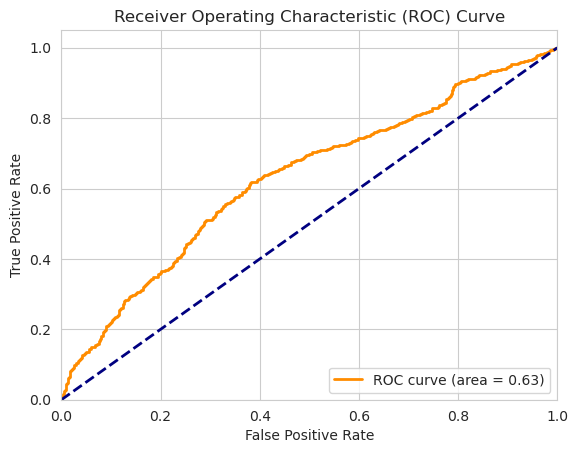

Optimal Threshold :  0.52
Model10_linh_scores_analysis


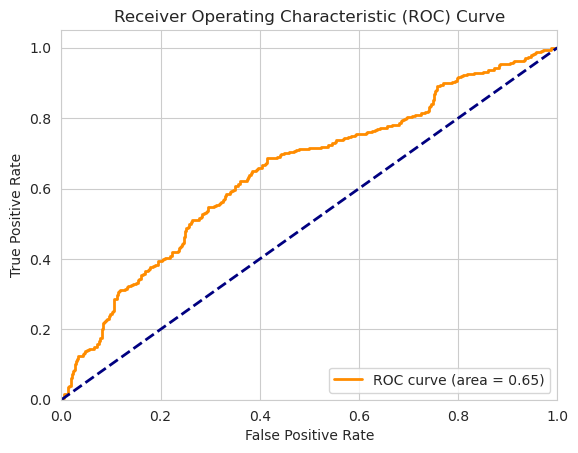

Optimal Threshold :  0.48


In [53]:
df_total_prob[10], df_linh_prob[10] = read_and_concat_predprob(10)
model_scores = pd.concat([model_scores,convert_predprob_to_scores(df_total_prob,10,'total')])
model_scores = pd.concat([model_scores,convert_predprob_to_scores(df_linh_prob,10,'linh')])

In [54]:
model_scores.model.unique()

array(['RF-OMC', 'BaseMax', 'BaseMaxLinh', 'Model1-total', 'Model1-linh',
       'Model2-total', 'Model2-linh', 'Model3-total', 'Model3-linh',
       'Model7-total', 'Model7-linh', 'Model10-total', 'Model10-linh'],
      dtype=object)

In [55]:
model_scores.to_csv("model_scores_mo123710.csv", index=None)

In [ ]:
print("Model\tf1\tmcc")
for mo in model_scores['model'].unique():
    if 'RF-OMC' in mo or 'inh' in mo:
        f1_mean = model_scores[(model_scores['model'] == mo) & (model_scores['Metric'] == 'f1_score')]['Score'].mean()
        mcc_mean = model_scores[(model_scores['model'] == mo) & (model_scores['Metric'] == 'mcc')]['Score'].mean()
        print(f"{mo}\t{f1_mean:.4f}\t{mcc_mean:.4f}")

In [ ]:
print("Model\tf1\tmcc")
for mo in model_scores['model'].unique():
    if 'RF-OMC' not in mo and 'inh' not in mo:
        f1_mean = model_scores[(model_scores['model'] == mo) & (model_scores['Metric'] == 'f1_score')]['Score'].mean()
        mcc_mean = model_scores[(model_scores['model'] == mo) & (model_scores['Metric'] == 'mcc')]['Score'].mean()
        print(f"{mo}\t{f1_mean:.4f}\t{mcc_mean:.4f}")

In [ ]:
model_scores[(model_scores['model'] == 'Model8-total') & 
             (model_scores['Metric'] == 'mcc') & 
             model_scores['Tumor'].isin(['BRCA','CRC'])]['Score'].mean()


In [ ]:
model_scores.to_csv("model_scores_all.csv")